<a href="https://colab.research.google.com/github/RocioLiu/Steel-Defect-Detection/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras

In [3]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


#### Load the dataset from Kaggle

In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import pathlib

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2

In [6]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle

In [0]:
# copy "kaggle.json" from "/content/kaggle.json" to "~/.kaggle/kaggle.json"
!cp /content/kaggle.json ~/.kaggle/kaggle.json

# "Your Kaggle API key is readable by other users on this system!"" To fix this, you can run 'chmod 600 /root/.kaggle/kaggle.json'
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Install Kaggle library
!pip install -q kaggle

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
#Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)

* Get the data

In [10]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.55G/1.57G [00:12<00:00, 156MB/s]
100% 1.57G/1.57G [00:12<00:00, 134MB/s]


Unzip train and test datasets

In [0]:
from zipfile import ZipFile

# This will extract all the files in stage1_test to current directory(/content)
with ZipFile("severstal-steel-defect-detection.zip", 'r') as zipObj:
# Extract all the contents of zip file in a folder "input"
    zipObj.extractall('/content/input')

#### read all text data


In [0]:
train_df = pd.read_csv("input/train.csv")
sample_df = pd.read_csv("input/sample_submission.csv")

In [19]:
#print("The number of training data: ",len(train_df))
print("The number of submission sample: ",len(sample_df))

The number of training data:  7095
The number of submission sample:  5506


In [14]:
train_df.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In [15]:
sample_df.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


First, check the number of each class

In [16]:
train_df.ClassId.value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

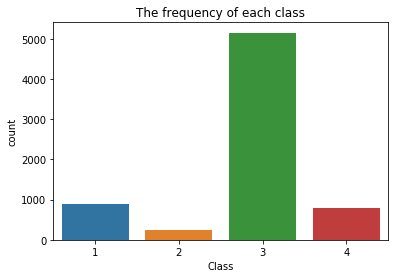

In [17]:
fig, ax = plt.subplots()
ax = sns.countplot(x="ClassId", data=train_df) # sns.countplot(train_df.ClassId)
ax.set_title('The frequency of each class')
ax.set_xlabel('Class');

As illustrated by this plot, our classes are highly imbalanced

In [0]:
# Get the directory of training images and test images
train_images_dir = '/content/input/train_images'
test_images_dir = '/content/input/test_images'

In [0]:
train_images_names = sorted([i for i in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, i))])
test_images_names = sorted([i for i in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, i))])

In [23]:
print("Total number of training images: ", len(os.listdir(train_images_dir)))
print("Total number of test images: ", len(os.listdir(test_images_dir)))

Total number of training images:  12568
Total number of test images:  5506


In [0]:
train_images = [os.path.join(train_images_dir, fname) for fname in train_images_names]
test_images = [os.path.join(test_images_dir, fname) for fname in test_images_names]

In [25]:
# As we can see, part of the steels are classified more the one type of defect
train_df.ImageId.value_counts()

ef24da2ba.jpg    3
db4867ee8.jpg    3
2c37ea89f.jpg    2
4d1444a12.jpg    2
0bc373e44.jpg    2
                ..
2eff528e8.jpg    1
43c1e8a0b.jpg    1
e7aff0392.jpg    1
61a365822.jpg    1
78ac37759.jpg    1
Name: ImageId, Length: 6666, dtype: int64

The names in train_images_names but not in train_df are the images that are not defect


In [0]:
# Extract the non defect images
defect_names = [x for x in train_images_names if x in train_df.ImageId.tolist()]
non_defect_names = [x for x in train_images_names if x not in train_df.ImageId.tolist()]

In [28]:
print("The number of non defect images: ", len(non_defect_names))
print("The number of defect images: ", len(defect_names))

The number of non defect images:  5902
The number of defect images:  6666


In [0]:
# Split the train images into defect and non-defect
defect_images = [os.path.join(train_images_dir, fname) for fname in defect_names]
non_defect_images = [os.path.join(train_images_dir, fname) for fname in non_defect_names]

#### check image data

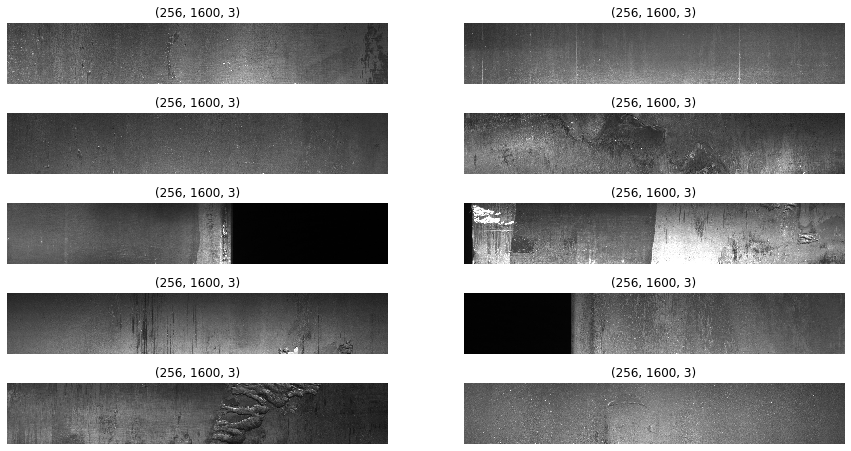

In [33]:
ROWS = 5
COLUMNS = 2

# Check the defect images
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(15,8))
for i, img_path in enumerate(defect_images[:10]):
  img = mpimg.imread(img_path)
  img_shape = img.shape

  x = i//COLUMNS
  y = i%COLUMNS
  axes[x, y].imshow(img)
  axes[x, y].axis('off')
  axes[x, y].set_title(img.shape)

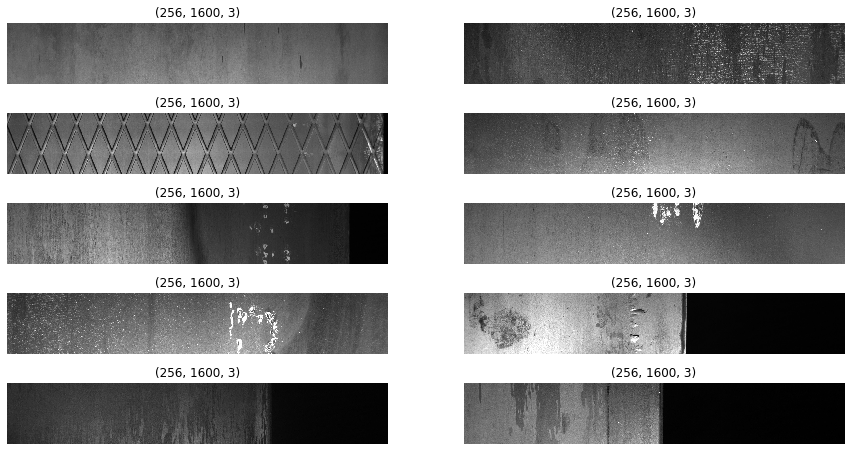

In [34]:
# Check the non-defect images
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(15,8))
for i, img_path in enumerate(non_defect_images[:10]):
  img = mpimg.imread(img_path)
  img_shape = img.shape

  x = i//COLUMNS
  y = i%COLUMNS
  axes[x, y].imshow(img)
  axes[x, y].axis('off')
  axes[x, y].set_title(img.shape)